#### Import packages

In [1]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn') 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import random
import cv2
import copy

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import torch.utils.data
import torch.utils.data as data_utils

seed = 0
# random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)
# from utils_3 import *
# from utils import *
# from utils_diff_ch import *
from utils_diff_ch_scaled import *

#### Load and Prepare Data

In [2]:
def scale_range (input_, max_, min_):
    input_[:,0,:,:] += -(-45.594448)
    input_[:,0,:,:] /= 82.68497099999999 / (max_ - min_)
    input_[:,0,:,:] += min_
    input_[:,1,:,:] += -(-49.083500000000001)
    input_[:,1,:,:] /= 69.686413000000002 / (max_ - min_)
    input_[:,1,:,:] += min_
    return input_

In [3]:
data = pd.read_json('./Data/train.json')
test = pd.read_json('./Data/test.json')

In [4]:
data['band_1'] = data['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

test['band_1'] = test['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
test['band_2'] = test['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')
test['not_machine_generated'] = test['inc_angle'].apply(lambda x: len(str(x))) <= 7

In [5]:
# Impute missing incidence angles
data_impute = data.dropna(axis=0, how='any')
data_impute_b1 = np.array([im.reshape(75*75) for im in data_impute.loc[:,'band_1']])
data_impute_b2 = np.array([im.reshape(75*75) for im in data_impute.loc[:,'band_2']])
data_impute_X = np.hstack(np.array((data_impute_b1, data_impute_b2, data_impute[['is_iceberg']])))
data_impute_y = np.array(data_impute[['inc_angle']])

data_impute_prec = data[~data.index.isin(data_impute.index.values)]
data_impute_b1_prec = np.array([im.reshape(75*75) for im in data_impute_prec.loc[:,'band_1']])
data_impute_b2_prec = np.array([im.reshape(75*75) for im in data_impute_prec.loc[:,'band_2']])
data_impute_X_prec = np.hstack(np.array((data_impute_b1_prec, data_impute_b2_prec, data_impute_prec[['is_iceberg']])))

modelImpute = LinearRegression()
modelImpute = modelImpute.fit(data_impute_X, data_impute_y)
data_impute_prec['inc_angle'] = modelImpute.predict(data_impute_X_prec)

data.loc[data_impute_prec.index] = data_impute_prec

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# Prepare data for autoencoder
orig_data = data
data = data.drop(['is_iceberg'], axis=1) \
            .append(test[test['not_machine_generated']].drop(['not_machine_generated'], axis=1)).reset_index() \
            .drop(['index'], axis=1)
        
train, val = train_test_split(data, test_size=0.2, random_state=42)
band_1_tr = np.concatenate([im for im in train['band_1']]).reshape(-1, 75, 75)
band_2_tr = np.concatenate([im for im in train['band_2']]).reshape(-1, 75, 75)
X_train = scale_range(np.stack((band_1_tr, band_2_tr), axis=1), -1, 1)

band_1_val = np.concatenate([im for im in val['band_1']]).reshape(-1, 75, 75)
band_2_val = np.concatenate([im for im in val['band_2']]).reshape(-1, 75, 75)
X_val = scale_range(np.stack((band_1_val, band_2_val), axis=1), -1, 1)

#### PyTorch Model

In [7]:
# Hyper Parameters
width = 75
height = 75
channels = 2
padding = 0
batch_size = 32

In [8]:
# Data Loader (Input Pipeline)
class icebergDataset(data_utils.Dataset):
    """Iceberg-Ship dataset."""

    def __init__(self, X, transform=None):
        self.X_images = X
        self.transform = transform

    def __len__(self):
        return len(self.X_images)

    def __getitem__(self, idx):
        im = self.X_images[idx]
        if self.transform:
            im = randomErodeDilate(im, u=0.5)
            im = randomZoomOut(im, u=0.5)
            im = randomNoisy(im, u=0.5)
            im = randomShift(im, u=0.5)
            im = randomRotation(im, u=0.5)
            
        return torch.from_numpy(im).float()

In [9]:
def save_checkpoint(state, is_best, filename='./Models/checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, './Models/model_best.pth.tar')

In [10]:
train_dataset = icebergDataset(X_train, transform=True)
val_dataset = icebergDataset(X_val)

In [11]:
act = nn.PReLU()
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.batch = nn.BatchNorm2d(channels)
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.Conv2d(18, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            
            nn.Conv2d(18, 36, kernel_size=3, padding=padding),
            nn.BatchNorm2d(36),
            act,
            nn.Conv2d(36, 54, kernel_size=3, padding=padding),
            nn.BatchNorm2d(54),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
        
            nn.Conv2d(54, 72, kernel_size=2, padding=padding),
            nn.BatchNorm2d(72),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
        
            nn.Conv2d(72, 144, kernel_size=2, padding=padding),
            nn.BatchNorm2d(144),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        
        
        self.decoder = nn.Sequential(
            nn.Conv2d(144, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.ConvTranspose2d(18, 128, kernel_size=4, stride=2, padding=padding),
            nn.BatchNorm2d(128),
            act,
            nn.Dropout(0.2),
        
            nn.ConvTranspose2d(128, 54, kernel_size=3, stride=2, padding=padding),
            nn.BatchNorm2d(54),
            act,
            nn.ConvTranspose2d(54, 36, kernel_size=3, stride=2, padding=padding),
            nn.BatchNorm2d(36),
            act,
            nn.Dropout(0.2),
        
            nn.ConvTranspose2d(36, 18, kernel_size=2, stride=2, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.Dropout(0.2),
        
            nn.ConvTranspose2d(18, 8, kernel_size=2, stride=2, padding=padding),
            nn.BatchNorm2d(8),
            act,
            nn.Conv2d(8, 2, kernel_size=2, padding=padding))        
        
        
    def forward(self, x_im):
#         x_im = self.batch(x_im)
        out = self.encoder(x_im)
        out = self.decoder(out)
        return out

In [12]:
def weight_init(m): 
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal(m.weight.data)

In [13]:
iceNet = autoencoder()
iceNet.apply(weight_init).cuda()

autoencoder (
  (batch): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True)
  (encoder): Sequential (
    (0): Conv2d(2, 18, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
    (2): PReLU (1)
    (3): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
    (5): PReLU (1)
    (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Dropout (p = 0.2)
    (8): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True)
    (10): PReLU (1)
    (11): Conv2d(36, 54, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True)
    (13): PReLU (1)
    (14): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (15): Dropout (p = 0.2)
    (16): Conv2d(54, 72, kernel_size=(2, 2), stride=(1, 1))
    (17): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True)
    (18): PReLU (1)

In [14]:
num_epochs = 39
batch_size = 64
learning_rate = 0.0005

In [15]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    for features in loader:
        features = features.cuda()
        labels = features.cuda()
        features = Variable(features, volatile=True)
        labels = Variable(labels, volatile=True).float()
        outputs = iceNet(features)
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        
    return np.mean(loss).data[0]

In [16]:
# Train the Model
best_prec1 = 1
for epoch in range(num_epochs):
    epoch_train_loss = []
    for i, (features) in enumerate(train_loader):
        iceNet.train()
        features = features.cuda()
        labels = features.cuda()
        features = Variable(features).float()
        labels = Variable(labels).float()
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = iceNet(features)
        loss = criterion(outputs, labels)
        epoch_train_loss.append(loss)
        loss.backward()
        optimizer.step()
        
    prec1 = accuracy(val_loader)
    print ('Epoch [%d/%d] \nTraining Loss: %.4f' % (epoch+1, num_epochs, np.mean(epoch_train_loss).data[0]))
    print('Validation Loss: %.4f' % accuracy(val_loader))
    
    is_best = prec1 < best_prec1
    best_prec1 = min(prec1, best_prec1)

print(best_prec1)

Epoch [1/39] 
Training Loss: 0.1439
Validation Loss: 0.0488
Epoch [2/39] 
Training Loss: 0.0455
Validation Loss: 0.0156
Epoch [3/39] 
Training Loss: 0.0219
Validation Loss: 0.0111
Epoch [4/39] 
Training Loss: 0.0159
Validation Loss: 0.0083
Epoch [5/39] 
Training Loss: 0.0129
Validation Loss: 0.0073
Epoch [6/39] 
Training Loss: 0.0113
Validation Loss: 0.0072
Epoch [7/39] 
Training Loss: 0.0105
Validation Loss: 0.0072
Epoch [8/39] 
Training Loss: 0.0101
Validation Loss: 0.0070
Epoch [9/39] 
Training Loss: 0.0097
Validation Loss: 0.0070
Epoch [10/39] 
Training Loss: 0.0095
Validation Loss: 0.0068
Epoch [11/39] 
Training Loss: 0.0092
Validation Loss: 0.0068
Epoch [12/39] 
Training Loss: 0.0088
Validation Loss: 0.0069
Epoch [13/39] 
Training Loss: 0.0089
Validation Loss: 0.0067
Epoch [14/39] 
Training Loss: 0.0086
Validation Loss: 0.0068
Epoch [15/39] 
Training Loss: 0.0085
Validation Loss: 0.0065
Epoch [16/39] 
Training Loss: 0.0085
Validation Loss: 0.0066
Epoch [17/39] 
Training Loss: 0.0

In [17]:
autoencoderNet = copy.deepcopy(iceNet)
autoencoderResetNet = copy.deepcopy(iceNet)

In [18]:
# tempNet = iceNet

#### Normal Supervised Learning Net with freezed convolutional layers

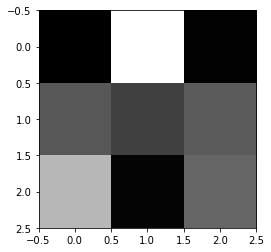

In [19]:
plt.imshow(iceNet.encoder[3].weight.data.cpu().numpy()[0][0], cmap='gray')
plt.show()

In [20]:
auto_data = data
data = orig_data

In [21]:
train, val = train_test_split(data, test_size=0.2, random_state=42)
band_1_tr = np.concatenate([im for im in train['band_1']]).reshape(-1, 75, 75)
band_2_tr = np.concatenate([im for im in train['band_2']]).reshape(-1, 75, 75)
X_train = scale_range(np.stack((band_1_tr, band_2_tr), axis=1), -1, 1)
X_train = [X_train, np.array(train['inc_angle']).reshape((len(train), 1))]

band_1_val = np.concatenate([im for im in val['band_1']]).reshape(-1, 75, 75)
band_2_val = np.concatenate([im for im in val['band_2']]).reshape(-1, 75, 75)
X_val = scale_range(np.stack((band_1_val, band_2_val), axis=1), -1, 1)
X_val = [X_val, np.array(val['inc_angle']).reshape((len(val), 1))]

band_1_test = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
band_2_test = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
# band_3_test = scale_range(band_1_test/band_2_test, -1, 1)
rgb = scale_range(np.stack((band_1_test, band_2_test), axis=1), -1, 1)
X_test = [rgb, np.array(test['inc_angle']).reshape((len(test), 1))]

y_train = train['is_iceberg'].values.astype(np.float32)
y_val = val['is_iceberg'].values.astype(np.float32)

In [22]:
# Data Loader (Input Pipeline)
class icebergDataset(data_utils.Dataset):
    """Iceberg-Ship dataset."""

    def __init__(self, X, y=None, transform=None, eval_=None):
        self.X_images = X[0]
        self.X_angles = torch.from_numpy(X[1]).float()
        if y!=None:
            self.y = torch.from_numpy(y.reshape((len(y),1))).float()
        else:
            self.y=None
        self.transform = transform
        self.eval_ = eval_

    def __len__(self):
        return len(self.X_images)

    def __getitem__(self, idx):
        im = self.X_images[idx]
        if self.transform:
#             if np.random.random() < 0.2:
#                 im = cv2.blur(im, (2,2))
            im = randomErodeDilate(im, u=0.3)
            im = randomZoomOut(im, u=0.5)
            im = randomNoisy(im, u=0.3)
            im = randomShift(im, u=0.5)
            im = randomRotation(im, u=0.3)
        if self.eval_:
            im = randomErodeDilate(im, u=0.2)
            im = randomZoomOut(im, u=0.4)
            im = randomNoisy(im, u=0.2)
            im = randomShift(im, u=0.4)
            im = randomRotation(im, u=0.2)
        try:
            if self.y==None:
                return [torch.from_numpy(im).float(), self.X_angles[idx]]
        except:
            pass
            
        return [torch.from_numpy(im).float(), self.X_angles[idx], self.y[idx]]

In [23]:
train_dataset = icebergDataset(X_train, y_train, transform=True)
val_dataset = icebergDataset(X_val, y_val)
test_dataset = icebergDataset(X_test)

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [24]:
act = nn.PReLU()
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.batch = nn.BatchNorm2d(channels)
        self.batch1D = nn.BatchNorm1d(1)
        self.features = nn.Sequential(
                    # stop at bottleneck
                    *list(autoencoderNet.children())[:-1]
                )
        self.fc1 = nn.Sequential(
            nn.Linear(1+(3*3*144), 512),
            act,
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(512, 196),
            act,
            nn.Dropout(0.5))
        self.fc3 = nn.Linear(196, 1)
        self.sig = nn.Sigmoid()
        
        
    def forward(self, x_im, x_angle):
        x_angle = self.batch1D(x_angle)
#         x_im = self.batch(x_im)
        out = self.features(x_im)
        out = out.view(out.size(0), -1)
        out = torch.cat([out, x_angle], dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [42]:
writer = SummaryWriter()
autoencoderNet = copy.deepcopy(autoencoderResetNet)
iceNet = net()
iceNet.cuda()

net (
  (batch): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True)
  (batch1D): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
  (features): Sequential (
    (0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True)
    (1): Sequential (
      (0): Conv2d(2, 18, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
      (2): PReLU (1)
      (3): Conv2d(18, 18, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True)
      (5): PReLU (1)
      (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (7): Dropout (p = 0.2)
      (8): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1))
      (9): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True)
      (10): PReLU (1)
      (11): Conv2d(36, 54, kernel_size=(3, 3), stride=(1, 1))
      (12): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True)
      (13): PReLU (1)
      (14): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)

In [43]:
num_epochs = 500
batch_size = 64
learning_rate = 0.0005

In [44]:
# # Freeze autoencoder feature layers
# for param in iceNet.parameters():
#     param.requires_grad = False

# gradParams = list(iceNet.parameters())
# for param in gradParams:
#     param.requires_grad = True

In [45]:
# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    for features, features_angle, labels in loader:
        features = features.cuda()
        labels = labels.cuda()
        features_angle = features_angle.cuda()
        features = Variable(features, volatile=True)
        features_angle = Variable(features_angle, volatile=True)
        labels = Variable(labels, volatile=True).float()
        outputs = iceNet(features, features_angle)
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        predicted = (F.sigmoid(outputs).data>0.5)
        total += labels.size(0)
        correct += (predicted == labels.byte().data).sum()
        
    return np.mean(loss).data[0], (100 * correct / total)

In [46]:
# Train the Model
loss_plot = []
best_prec1 = 1
for epoch in range(num_epochs):
    epoch_train_loss = []
    for i, (features, features_angle, labels) in enumerate(train_loader):
        iceNet.train()
        features = features.cuda()
        labels = labels.cuda()
        features = Variable(features).float()
        features_angle = Variable(features_angle).cuda()
        labels = Variable(labels).float()
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = iceNet(features, features_angle)
        writer.add_graph(iceNet, outputs)
#         writer.add_histogram('hist_fc1', iceNet.features_1[1].weight.data.cpu().numpy(), i)
#         writer.add_histogram('hist_fc2', iceNet.features_1[3].weight.data.cpu().numpy(), i)
#         writer.add_histogram('hist_fc3', iceNet.features_2.weight.data.cpu().numpy(), i)
        loss = criterion(outputs, labels)
        epoch_train_loss.append(loss)
        loss.backward()
        optimizer.step()
        
    acc = accuracy(val_loader)
    prec1 = acc[0]
    tr_loss = np.mean(epoch_train_loss).data[0]
    loss_plot.append([prec1, tr_loss])
    print ('Epoch [%d/%d] \nTraining Loss: %.4f' % (epoch+1, num_epochs, tr_loss))
    print('Validation Loss: %.4f, Accuracy: %.2f%%' % acc)
    
    is_best = prec1 < best_prec1
    best_prec1 = min(prec1, best_prec1)
#     save_checkpoint({
#         'epoch': epoch + 1,
#         'state_dict': iceNet.state_dict(),
#         'best_prec1': best_prec1,
#         'optimizer' : optimizer.state_dict(),
#     }, is_best)

print(best_prec1)
# export scalar data to JSON for external processing
writer.close()

Epoch [1/500] 
Training Loss: 0.6494
Validation Loss: 0.7123, Accuracy: 52.34%
Epoch [2/500] 
Training Loss: 0.5563
Validation Loss: 0.5734, Accuracy: 65.42%
Epoch [3/500] 
Training Loss: 0.5071
Validation Loss: 0.7398, Accuracy: 72.90%
Epoch [4/500] 
Training Loss: 0.5093
Validation Loss: 0.4041, Accuracy: 78.19%
Epoch [5/500] 
Training Loss: 0.4602
Validation Loss: 0.3629, Accuracy: 78.82%
Epoch [6/500] 
Training Loss: 0.4637
Validation Loss: 0.4102, Accuracy: 75.08%
Epoch [7/500] 
Training Loss: 0.4547
Validation Loss: 0.3865, Accuracy: 78.82%
Epoch [8/500] 
Training Loss: 0.4790
Validation Loss: 0.4081, Accuracy: 76.64%
Epoch [9/500] 
Training Loss: 0.5300
Validation Loss: 0.6363, Accuracy: 79.13%
Epoch [10/500] 
Training Loss: 0.4176
Validation Loss: 0.4079, Accuracy: 76.64%
Epoch [11/500] 
Training Loss: 0.4354
Validation Loss: 0.3477, Accuracy: 81.00%
Epoch [12/500] 
Training Loss: 0.4181
Validation Loss: 0.3287, Accuracy: 85.36%
Epoch [13/500] 
Training Loss: 0.3815
Validation 

KeyboardInterrupt: 

In [29]:
plt.figure(figsize=(17,8))
plt.plot(loss_plot)
plt.legend(['Val', 'Train'])
plt.show()
print(best_prec1)

NameError: name 'loss_plot' is not defined

In [85]:
print("=> loading checkpoint")
best_model = torch.load('./Models/model_best.pth.tar')
print('best_prec1 = ', best_model['best_prec1'])
iceNet.load_state_dict(best_model['state_dict'])
optimizer.load_state_dict(best_model['optimizer'])

=> loading checkpoint
best_prec1 =  0.19683799147605896


KeyError: 'missing keys in state_dict: "{\'layer1.9.weight\', \'layer1.9.bias\'}"'

In [124]:
temp_dataset = icebergDataset(X_train)

In [129]:
# Predict
iceNet.eval()
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
results = []
for features, features_angle in test_loader:
    iceNet.eval()
    features = Variable(features, volatile=True).cuda()
    features_angle = Variable(features_angle, volatile=True).cuda()
    outputs = F.softmax(iceNet(features, features_angle))
#     outputs = iceNet(features, features_angle)

    results.append(outputs.data[0][1])

In [132]:
sub = pd.read_csv('./Data/sample_submission.csv')

In [133]:
sub['is_iceberg'] = results

In [135]:
sub.to_csv('./Submissions/sub_30Oct_val_1631.csv', index=False)

#### KFold

In [25]:
def weight_init(m): 
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal(m.weight.data)

In [51]:
# Import psuedo labels
psuedo = pd.read_csv('./Submissions/Sub 31 - 5-fold _ Val-1753.csv')
psuedo = psuedo[np.abs(psuedo['is_iceberg'])>0.95]
psuedo['is_iceberg'] = np.array((psuedo['is_iceberg']>0.5), np.int)
psuedo_test = test.join(psuedo.set_index('id'), how='right', on='id')

data = data.append(psuedo_test[psuedo_test['not_machine_generated']].drop(['not_machine_generated']
                                                                          , axis=1)).reset_index() \
        .drop(['index'], axis=1)

In [54]:
band_1_KF = np.concatenate([im for im in data['band_1']]).reshape(-1, 75, 75)
band_2_KF = np.concatenate([im for im in data['band_2']]).reshape(-1, 75, 75)
# band_3_KF = scale_range(band_1_KF/band_2_KF, -1, 1)
X_KF = scale_range(np.stack((band_1_KF, band_2_KF), axis=1), -1, 1)
X_KF = [X_KF, np.array(data['inc_angle']).reshape((len(data), 1))]

# X_test[0] = scale_test_range(X_test[0], train_min, train_max, -1, 1)
y_KF = data['is_iceberg'].values.astype(np.float32)

In [55]:
def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    predicted_val = []
    for features, features_angle, labels in loader:
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        labels = Variable(labels, volatile=True).cuda().float()
        outputs = iceNet(features, features_angle)
        predicted_val.append(outputs.data[:].cpu().numpy())
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        predicted = (F.sigmoid(outputs).data>0.5)
        total += labels.size(0)
        correct += (predicted == labels.byte().data).sum()
    return np.mean(loss).data[0], (100 * correct / total), np.concatenate(predicted_val)

In [56]:
num_epochs = 500
batch_size = 64
learning_rate = 0.0005

In [91]:
# kfold = 5
# kfold_scores = []

# test_dataset = icebergDataset(X_test)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# results = []
# fold_predictions = []
# sss = KFold(n_splits=kfold, random_state=0)
# for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
#     X_train_KF = [X_KF[0][train_index], X_KF[1][train_index]]
#     X_valid_KF = [X_KF[0][test_index], X_KF[1][test_index]]
#     y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]
    
#     # Define model
#     autoencoderNet = copy.deepcopy(autoencoderResetNet)
#     iceNet = net().cuda()
    
#     # Loss and Optimizer
#     criterion = nn.BCEWithLogitsLoss()
#     optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)
    
#     # Data Loader
#     train_dataset_KF = icebergDataset(X_train_KF, y_train_KF, transform=True)
#     val_dataset_KF = icebergDataset(X_valid_KF, y_valid_KF)

#     train_loader_KF = torch.utils.data.DataLoader(dataset=train_dataset_KF, batch_size=batch_size, shuffle=True)
#     val_loader_KF = torch.utils.data.DataLoader(dataset=val_dataset_KF, batch_size=batch_size, shuffle=False)
    
#     print('Fold [%d/%d]' % (i+1, kfold))
#     # Train
#     best_prec1 = 1
#     for epoch in range(num_epochs):
#         epoch_train_loss = []
#         for idx, (features, features_angle, labels) in enumerate(train_loader_KF):
#             iceNet.train()
#             features = Variable(features).cuda()
#             features_angle = Variable(features_angle).cuda()
#             labels = Variable(labels).cuda().float()
#             # Forward + Backward + Optimize
#             optimizer.zero_grad()
#             outputs = iceNet(features, features_angle)
#             loss = criterion(outputs, labels)
#             epoch_train_loss.append(loss)
#             loss.backward()
#             optimizer.step()

#         acc = accuracy(val_loader_KF)
#         prec1 = acc[0]

#         # Save best model
#         is_best = prec1 < best_prec1
#         best_prec1 = min(prec1, best_prec1)
#         if is_best:
#             best_fold_predictions = acc[2]
#         save_checkpoint({
#             'epoch': epoch + 1,
#             'state_dict': iceNet.state_dict(),
#             'best_prec1': best_prec1,
#             'optimizer' : optimizer.state_dict(),
#         }, is_best, filename='./Models/v1Nov_v1/model_fold_'+str(i+1)+'.pth.tar')
        
#     print('Val Score : %f' % (best_prec1))
#     fold_predictions.append(best_fold_predictions)
#     kfold_scores.append(best_prec1)
#     # Load best model
#     best_model = torch.load('./Models/v1Nov_v1/model_fold_'+str(i+1)+'.pth.tar')
#     iceNet.load_state_dict(best_model['state_dict'])
#     optimizer.load_state_dict(best_model['optimizer'])
    
#     # Predict
#     iceNet.eval()
    
#     results_fold = []
#     for features, features_angle in test_loader:
#         iceNet.eval()
#         features = Variable(features, volatile=True).cuda()
#         features_angle = Variable(features_angle, volatile=True).cuda()
#         outputs = F.sigmoid(iceNet(features, features_angle))
#     #     outputs = iceNet(features, features_angle)

#         results_fold.append(outputs.data.cpu().numpy()[0][0])        
    
#     results.append(np.array(results_fold))

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Fold [1/5]
Val Score : 0.149972
Fold [2/5]
Val Score : 0.158772
Fold [3/5]
Val Score : 0.209527
Fold [4/5]


KeyboardInterrupt: 

In [58]:
kfold = 5
kfold_scores = []

test_dataset = icebergDataset(X_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

results = []
fold_predictions = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0][:1604], X_KF[1][:1604], y_KF[:1604])):
    sample_rate = 0.5
    psuedo_samples = np.random.choice(np.arange(1604, len(data)), int((len(data)-1604)*sample_rate), replace=False)
    X_train_KF = [np.vstack((X_KF[0][train_index],X_KF[0][psuedo_samples])), np.vstack((X_KF[1][train_index],X_KF[1][psuedo_samples]))]
    X_valid_KF = [X_KF[0][test_index], X_KF[1][test_index]]
    y_train_KF, y_valid_KF = np.concatenate((y_KF[train_index],y_KF[psuedo_samples])), y_KF[test_index]
    
    # Define model
    autoencoderNet = copy.deepcopy(autoencoderResetNet)
    iceNet = net().cuda()
    
    # Loss and Optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)
    
    # Data Loader
    train_dataset_KF = icebergDataset(X_train_KF, y_train_KF, transform=True)
    val_dataset_KF = icebergDataset(X_valid_KF, y_valid_KF)

    train_loader_KF = torch.utils.data.DataLoader(dataset=train_dataset_KF, batch_size=batch_size, shuffle=True)
    val_loader_KF = torch.utils.data.DataLoader(dataset=val_dataset_KF, batch_size=batch_size, shuffle=False)
    
    print('Fold [%d/%d]' % (i+1, kfold))
    # Train
    best_prec1 = 1
    for epoch in range(num_epochs):
        epoch_train_loss = []
        for idx, (features, features_angle, labels) in enumerate(train_loader_KF):
            iceNet.train()
            features = Variable(features).cuda()
            features_angle = Variable(features_angle).cuda()
            labels = Variable(labels).cuda().float()
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = iceNet(features, features_angle)
            loss = criterion(outputs, labels)
            epoch_train_loss.append(loss)
            loss.backward()
            optimizer.step()

        acc = accuracy(val_loader_KF)
        prec1 = acc[0]

        # Save best model
        is_best = prec1 < best_prec1
        best_prec1 = min(prec1, best_prec1)
        if is_best:
            best_fold_predictions = acc[2]
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': iceNet.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict(),
        }, is_best, filename='./Models/v1Nov_v1/model_fold_'+str(i+1)+'.pth.tar')
        
    print('Val Score : %f' % (best_prec1))
    fold_predictions.append(best_fold_predictions)
    kfold_scores.append(best_prec1)
    # Load best model
    best_model = torch.load('./Models/v1Nov_v1/model_fold_'+str(i+1)+'.pth.tar')
    iceNet.load_state_dict(best_model['state_dict'])
    optimizer.load_state_dict(best_model['optimizer'])
    
    # Predict
    iceNet.eval()
    
    results_fold = []
    for features, features_angle in test_loader:
        iceNet.eval()
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        outputs = F.sigmoid(iceNet(features, features_angle))
    #     outputs = iceNet(features, features_angle)

        results_fold.append(outputs.data.cpu().numpy()[0][0])        
    
    results.append(np.array(results_fold))

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Fold [1/5]
Val Score : 0.141197
Fold [2/5]
Val Score : 0.138402
Fold [3/5]
Val Score : 0.202200
Fold [4/5]
Val Score : 0.140164
Fold [5/5]
Val Score : 0.193309


In [59]:
np.array(kfold_scores).mean()

0.16305434703826904

In [60]:
np.array(kfold_scores).std()

0.028485772863673157

In [36]:
np.array(sub['is_iceberg']<0.5).sum()

6128

In [48]:
sub_num = 51
os.makedirs("./Models/Sub "+str(sub_num))
np.savetxt("./Models/Sub "+str(sub_num)+"/results.csv", np.array(results), delimiter=",")
np.savetxt("./Models/Sub "+str(sub_num)+"/cv_fold_results.csv", np.concatenate(fold_predictions), delimiter=",")
sub = pd.read_csv('./Data/sample_submission.csv')
sub['is_iceberg'] = np.array(results).mean(axis=0)
sub.to_csv('./Submissions/Sub '+str(sub_num)+' - 5-fold _ Val-1525.csv', index=False)

In [2]:
sub = pd.read_csv('./Data/sample_submission.csv')

In [3]:
sub1 = pd.read_csv('./Submissions/Sub 24 - 5-fold _ Val-1770.csv')['is_iceberg']
sub2 = pd.read_csv('./Submissions/Sub 25 - 5-fold _ Val-1757.csv')['is_iceberg']
sub3 = pd.read_csv('./Submissions/Sub 26 - 5-fold _ Val-1802.csv')['is_iceberg']
sub4 = pd.read_csv('./Submissions/Sub 27 - 5-fold _ Val-1839.csv')['is_iceberg']
# sub5 = pd.read_csv('./Submissions/Sub 8 - 5-fold _ Val-1479.csv')['is_iceberg']
# sub6 = pd.read_csv('./Submissions/Sub 16 - 5-fold _ Val-1422.csv')['is_iceberg']

In [4]:
results = 1/np.mean((1/np.array(sub1), 1/np.array(sub3),
                   1/np.array(sub4), 1/np.array(sub2)), axis=0)
sub['is_iceberg'] = np.array(results)
sub.to_csv('./Submissions/Sub 29 - Ensemble_24_25_26_27 - Harmonic Mean.csv', index=False)

#### Error Analysis

In [24]:
def accuracy(loader):
    iceNet.eval()
    correct = 0
    total = 0
    loss = []
    inc_features = []
    inc_feature_angles = []
    inc_labels = []
    for features, features_angle, labels in loader:
        features = Variable(features, volatile=True).cuda()
        features_angle = Variable(features_angle, volatile=True).cuda()
        labels = Variable(labels, volatile=True).cuda()
        outputs = iceNet(features, features_angle)
        _loss = criterion(outputs, labels)
        loss.append(_loss)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        inc_features.append(features.data.cpu().numpy()[np.where((predicted!=labels.data).cpu().numpy())])
        inc_feature_angles.append(features_angle.data.cpu().numpy()[np.where((predicted!=labels.data).cpu().numpy())])
        inc_labels.append(labels.data.cpu().numpy()[np.where((predicted!=labels.data).cpu().numpy())])
        
    return np.mean(loss).data[0], (100 * correct / total), [inc_features, inc_feature_angles, inc_labels]

In [25]:
kfold = 5
kfold_scores = []

results = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X_KF[0], X_KF[1], y_KF)):
    if i == 2:
        X_train_KF, X_valid_KF = [X_KF[0][train_index], X_KF[1][train_index]], [X_KF[0][test_index], X_KF[1][test_index]]
        y_train_KF, y_valid_KF = y_KF[train_index], y_KF[test_index]

        # Define model
        iceNet = net().apply(weight_init).cuda()

        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(iceNet.parameters(), lr=learning_rate, weight_decay=0.0001)

        # Data Loader
        train_dataset_KF = icebergDataset(X_train_KF, y_train_KF, transform=True)
        val_dataset_KF = icebergDataset(X_valid_KF, y_valid_KF)

        train_loader_KF = torch.utils.data.DataLoader(dataset=train_dataset_KF, batch_size=batch_size, shuffle=True)
        val_loader_KF = torch.utils.data.DataLoader(dataset=val_dataset_KF, batch_size=batch_size, shuffle=False)

        print('Fold [%d/%d]' % (i+1, kfold))
        # Train
        best_prec1 = 1
        for epoch in range(num_epochs):
            epoch_train_loss = []
            for idx, (features, features_angle, labels) in enumerate(train_loader_KF):
                iceNet.train()
                features = Variable(features).cuda()
                features_angle = Variable(features_angle).cuda()
                labels = Variable(labels).cuda()
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = iceNet(features, features_angle)
                loss = criterion(outputs, labels)
                epoch_train_loss.append(loss)
                loss.backward()
                optimizer.step()
            
            acc = accuracy(val_loader_KF)
            prec1 = acc[0]

            # Save best model
            is_best = prec1 < best_prec1
            best_prec1 = min(prec1, best_prec1)
            if is_best:
                incorrect = acc[2]
print(best_prec1)

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Fold [3/5]
0.2119673639535904


In [26]:
incorrect[0] = np.vstack(incorrect[0])
incorrect[1] = np.vstack(incorrect[1])
incorrect[2] = np.hstack(incorrect[2])

In [46]:
def randomZoomOut(im, zoom_ratio=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        height, width = im[0].shape
        
        zoom = height*np.random.uniform(zoom_ratio[0], zoom_ratio[1])
        if int(zoom)<0:
            zoom = abs(int(zoom))
            im_0 = cv2.resize(im[0, zoom//2:-zoom//2, zoom//2:-zoom//2], (height, width))
            im_1 = cv2.resize(im[1, zoom//2:-zoom//2, zoom//2:-zoom//2], (height, width))
#            im_2 = cv2.resize(im[2, zoom//2:-zoom//2, zoom//2:-zoom//2], (height, width))
#            im_3 = cv2.resize(im[3, zoom//2:-zoom//2, zoom//2:-zoom//2], (height, width))
            return np.stack((im_0,im_1))
        
        if zoom<0:
            zoom = 0
        im_0 = cv2.resize(cv2.copyMakeBorder(im[0],int(zoom//2),int(zoom//2),int(zoom//2),int(zoom//2),
                                   cv2.BORDER_REFLECT101), (height, width))
        im_1 = cv2.resize(cv2.copyMakeBorder(im[1],int(zoom//2),int(zoom//2),int(zoom//2),int(zoom//2),
                                   cv2.BORDER_WRAP), (height, width))
#        im_2 = cv2.resize(cv2.copyMakeBorder(im[2],int(zoom//2),int(zoom//2),int(zoom//2),int(zoom//2),
#                                   cv2.BORDER_REPLICATE), (height, width))
#        im_3 = cv2.resize(cv2.copyMakeBorder(im[3],int(zoom//2),int(zoom//2),int(zoom//2),int(zoom//2),
#                                   cv2.BORDER_REPLICATE), (height, width))
        return np.stack((im_0,im_1))
    
    return im

In [47]:
for idx, im in enumerate(incorrect[0]):
    f, axarr = plt.subplots(2, 2, figsize=(10,8))
    plt.title('Label = '+str(incorrect[2][idx])+', Inc Angle = '+str(incorrect[1][idx][0]))
    zm = randomZoomOut(im, (0, 0.5), 1)
    axarr[0, 0].imshow(im[0], cmap='gray')
    axarr[0, 1].imshow(im[1], cmap='gray')
    axarr[1, 0].imshow(zm[0], cmap='gray')
    axarr[1, 1].imshow(zm[1], cmap='gray')
    plt.show()

error: /home/travis/miniconda/conda-bld/conda_1486587069159/work/opencv-3.1.0/modules/core/src/copy.cpp:928: error: (-5) Unknown/unsupported border type in function borderInterpolate
